## EDA Visualizations

(Shristi Pandey)

In this section, we will be looking performing exploratory data analysis on the adnimerge dataset, visualizing data and cleaning it up to a per-patient database

In [1]:
import pandas as pd 
import datetime
import numpy as np 
import scipy as sp
from scipy.stats import mode
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
data_first_idx = pd.read_csv("../data/Cleaned/patient_firstidx_merge.csv")
data_non_missing = pd.read_csv("../data/Cleaned/patient_nonmissingidx_merge.csv")
adnimerge = pd.read_csv("../data/ADNIMERGE.csv")
print(adnimerge.shape)
print(data_first_idx.shape)
adnimerge.head()

(13632, 113)
(3652, 201)


/Users/ShristiPandey/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,...,NaN,NaN,1.36665,NaN,NaN,0.000000,0.00000,0,0,2018-10-19 22:51:15.0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.000000,0.00000,0,0,2018-10-19 22:51:15.0
2,3,011_S_0003,m06,11,ADNI1,ADNI1,2006-03-13,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.498289,5.96721,6,6,2018-10-19 22:51:15.0
3,3,011_S_0003,m12,11,ADNI1,ADNI1,2006-09-12,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.999316,11.96720,12,12,2018-10-19 22:51:15.0
4,3,011_S_0003,m24,11,ADNI1,ADNI1,2007-09-12,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,1.998630,23.93440,24,24,2018-10-19 22:51:15.0


First look at the data just to see the amount of missing data in the raw adnimerge data: 

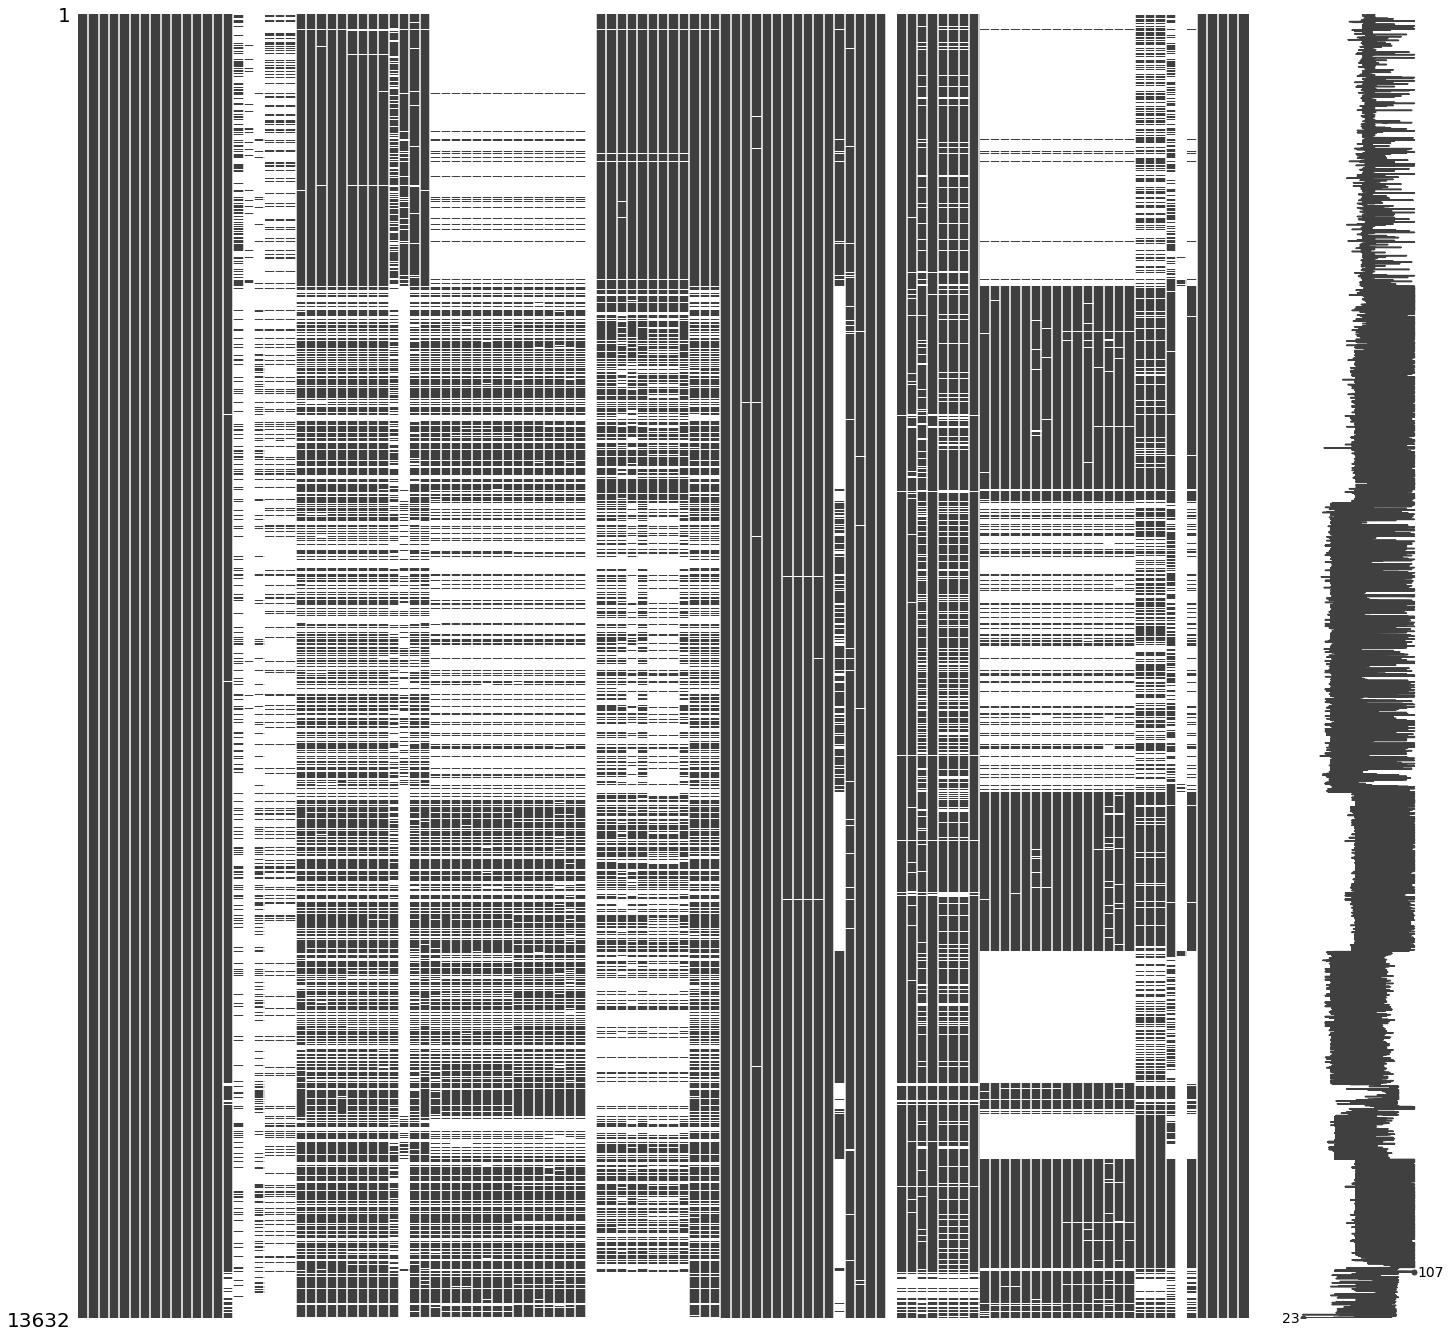

In [3]:
fig = msno.matrix(adnimerge, figsize=(24, 24), width_ratios=(10,1), sparkline=True)

First things first, we are going to remove all the 99 to 100% fully missing columns 

In [4]:
baseline_only = adnimerge[adnimerge['VISCODE'] == 'bl']

First of all if DX or DX_bl are missing, lets look at the proportion of patients in each of the different diagnostic categories. 

In [5]:
print("Full data:", adnimerge.shape)
print("Per patient data:", baseline_only.shape )

Full data: (13632, 113)
Per patient data: (2081, 113)


In [6]:
# percent missing
def find_percent_missing(adnimerge): 
    cols_with_nulls = adnimerge.columns[adnimerge.isnull().any()]

    colnames = []
    missing = []
    missing_pct = []

    for col in cols_with_nulls:
        colnames.append(col)
        missing.append(len(adnimerge[col][adnimerge[col].isnull()]))
        missing_pct.append(100 * len(adnimerge[col][adnimerge[col].isnull()])/len(adnimerge[col]))
    
    missing_pct = pd.DataFrame({'names': colnames, 'Percent_data_missing': missing_pct})
    
    return missing_pct

In [7]:
missing_columns = find_percent_missing(adnimerge)
missing_columns = missing_columns.sort_values(by=['Percent_data_missing'], ascending=False) 


missing_columns_per_patient = find_percent_missing(baseline_only)
missing_columns_per_patient = missing_columns_per_patient.sort_values(by=['Percent_data_missing'], ascending=False) 

Text(0.5,0.98,'Missing data by feature')

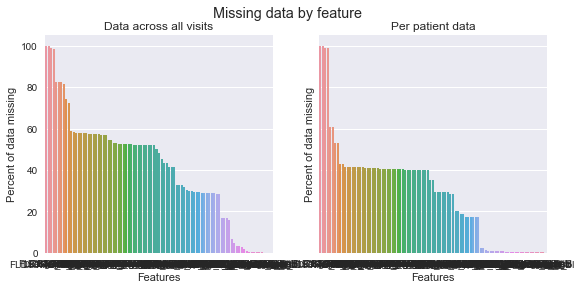

In [8]:
sns.set()
f, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True, sharex=True)
sns.barplot(x = 'names', y = 'Percent_data_missing',  data = missing_columns, orient='H', ax = axes[0])
axes[0].set_title('Data across all visits')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Percent of data missing')

sns.barplot(x = 'names', y = 'Percent_data_missing',  data = missing_columns_per_patient, orient='H', ax = axes[1])
axes[1].set_title('Per patient data')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Percent of data missing')

f.suptitle('Missing data by feature')

There are a number of missing values in the final diagnosis category and a smaller number of NAs in the baseline diagnosis. The patients that have no value for diagnostic group is not useful because diagnostic category will serve to be our response variable. Hence, we will remove  those patient entries in which either baseline or final diagnosis is na.

Text(0.5,0.98,'Distribution of percent missingness among the features of the data')

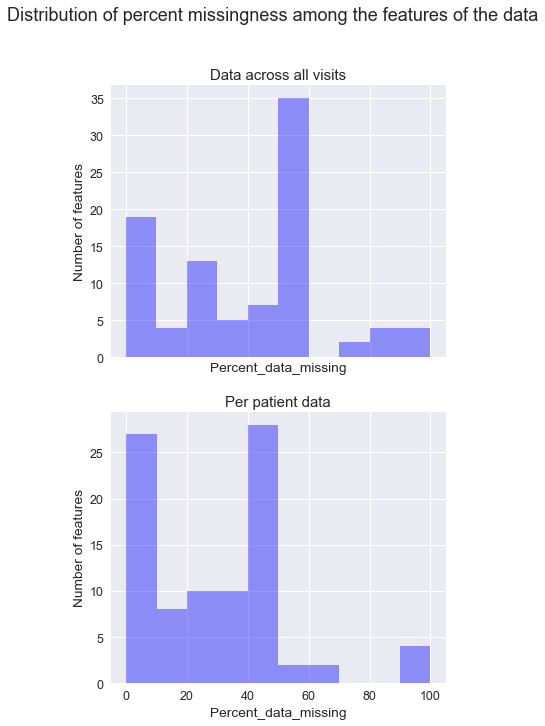

In [9]:
sns.set(font_scale = 1.25)

f, axes = plt.subplots(2, 1, figsize=(6, 11), sharey=False, sharex=True)

sns.distplot(missing_columns['Percent_data_missing'], color = 'b', kde= False, bins= 10, ax = axes[0])
axes[0].set_title('Data across all visits')
axes[0].set_ylabel('Number of features')
sns.distplot(missing_columns_per_patient['Percent_data_missing'], color = 'b', kde= False, bins= 10, ax = axes[1])
axes[1].set_title('Per patient data')
axes[1].set_ylabel('Number of features')

f.suptitle('Distribution of percent missingness among the features of the data')


In [10]:
#remove NA in diagnosis: 
adnimerge2 = adnimerge.dropna(subset = ['DX_bl', 'DX'])

In [11]:
print("Shape of the full dataset after removing the completely useless rows:", adnimerge2.shape)


Shape of the full dataset after removing the completely useless rows: (9665, 113)


 Also note that because of the way that the ADNI study was designed, the baseline diagnosis has more MCI categories than the final diagnosis. We will collapse the extra categories in the following way: 

1. EMCI and LMCI: MCI 
2. SMCI: CN (Since these are self reported)

In [12]:
#merge EMCI and LMCI into MCI and SMC with CN. 
adnimerge.drop_duplicates('DX_bl')[['DX_bl', 'DX']]

,DX_bl,DX
0,CN,CN
1,AD,Dementia
5,LMCI,MCI
48,SMC,CN
2848,EMCI,MCI
11389,NaN,NaN


In [13]:
adnimerge2['DX_bl'] = adnimerge2['DX_bl'].map({'LMCI': 'MCI', 'SMC': 'CN', 'EMCI': 'MCI', 'CN': 'CN', 'AD': 'AD'})
adnimerge2['DX'] = adnimerge2['DX'].map({'CN': 'CN', 'MCI': 'MCI', 'Dementia': 'AD'})

/Users/ShristiPandey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ShristiPandey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
adnimerge2.drop_duplicates('DX_bl')[['DX_bl', 'DX']]

,DX_bl,DX
0,CN,CN
1,AD,AD
5,MCI,MCI


In [15]:
len(adnimerge['RID'].unique())

2081

In [16]:
baseline_only_2 = adnimerge2[adnimerge2['VISCODE'] == 'bl']
print("Shape of the per patient dataset after removing the completely useless rows:", baseline_only_2.shape)

Shape of the per patient dataset after removing the completely useless rows: (2056, 113)


In [17]:
adnimerge2.drop_duplicates('DX_bl')[['DX_bl', 'DX']]

,DX_bl,DX
0,CN,CN
1,AD,AD
5,MCI,MCI


At this point for ease of operation, I will split the data and take only the baseline values. However, to keep track of the final diagnosis for each patient, I will create a DX_FINAL category that I will add to the baseline data so that I can keep track of how many patients change their diagnosis. 

In [18]:
def find_final_diagnosis(df): 
    final_diag = []
    groups = df.groupby('RID').groups
    for group in groups: 
        last_index = groups[group][-1]
        diagnosis = df['DX'].loc[last_index]
        final_diag.append(diagnosis)
    return final_diag

final_dx = find_final_diagnosis(adnimerge2)
baseline_only_2['final_dx'] = final_dx

/Users/ShristiPandey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [19]:
baseline_only_2.shape

(2056, 114)

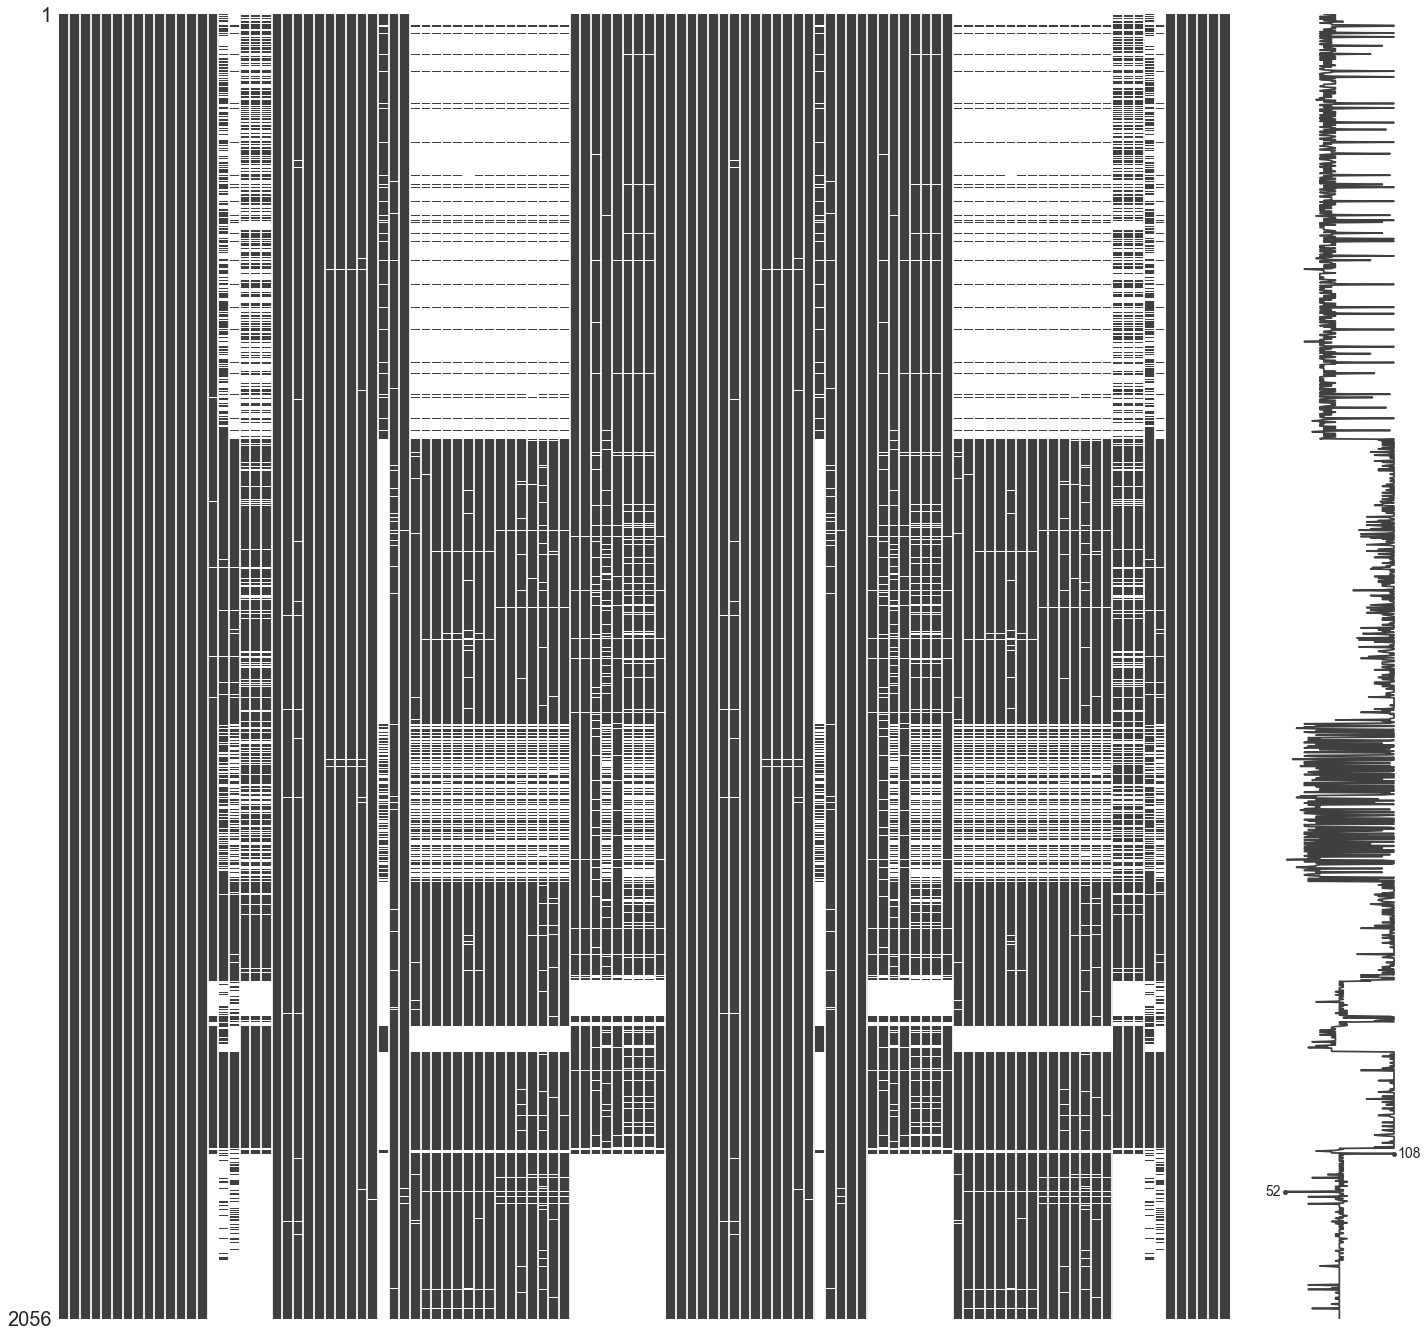

In [88]:
 msno.matrix(baseline_only_2, figsize=(24, 24), width_ratios=(10,1), sparkline=True)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

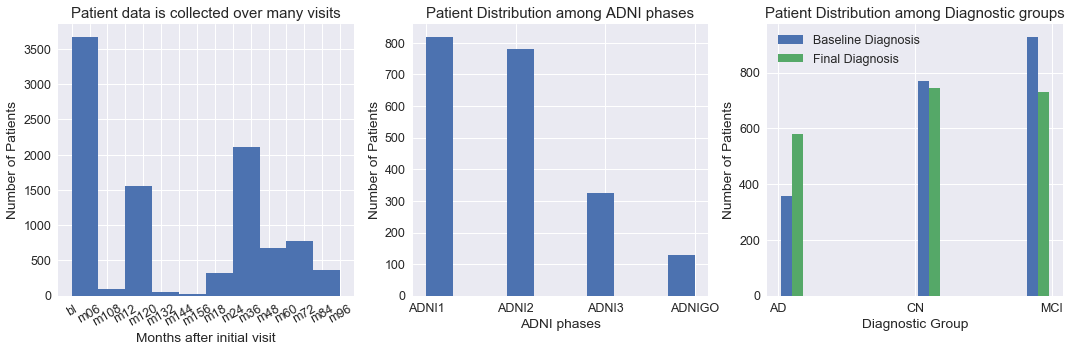

In [20]:
diagnosis = baseline_only_2[['DX', 'final_dx', 'ORIGPROT']]
#diagnosis.groupby('')

sns.set(font_scale=1.25)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (18, 5))

ax3.hist(x = diagnosis[['DX', 'final_dx']])
ax3.set_xlabel('Diagnostic Group')
ax3.set_ylabel('Number of Patients')
ax3.legend(['Baseline Diagnosis', 'Final Diagnosis'])
ax3.set_title('Patient Distribution among Diagnostic groups')


ax2.hist(diagnosis['ORIGPROT'])
ax2.set_xlabel('ADNI phases')
ax2.set_ylabel('Number of Patients')
ax2.set_title('Patient Distribution among ADNI phases')

ax1.hist(adnimerge2[['VISCODE']])
ax1.set_xlabel('Months after initial visit')
ax1.set_ylabel('Number of Patients')
ax1.set_title('Patient data is collected over many visits')
plt.setp(ax1.get_xticklabels(), rotation=30)



In [21]:
baseline_only_2.shape

(2056, 114)

In [22]:
#Now lets just remove the four columns that are completley useless because they are 98 to 100% missing. 
baseline_only_2 = baseline_only_2.drop(labels=['FLDSTRENG', 'FLDSTRENG_bl', 'PIB', 'PIB_bl'], axis=1)
baseline_only_2.shape

(2056, 110)

**Now lets investigate some patient demographics**

At this point we have a per patient database with the absolutely useless rows and columns removed. At this point, we have 2056 patients and 114 features. Using this data, we will look at demographics among the different diagnostic categories. 

Later, we will also then begin looking at correlations between the remaining columns and make decisions on which ones we will remove. 

In [83]:
# lets sort out just the demographic measures. 
demographics  = baseline_only_2[['DX', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTRACCAT', 'PTMARRY', 'PTETHCAT']]

/Users/ShristiPandey/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0.98,'Figure2: Patient Demographics')

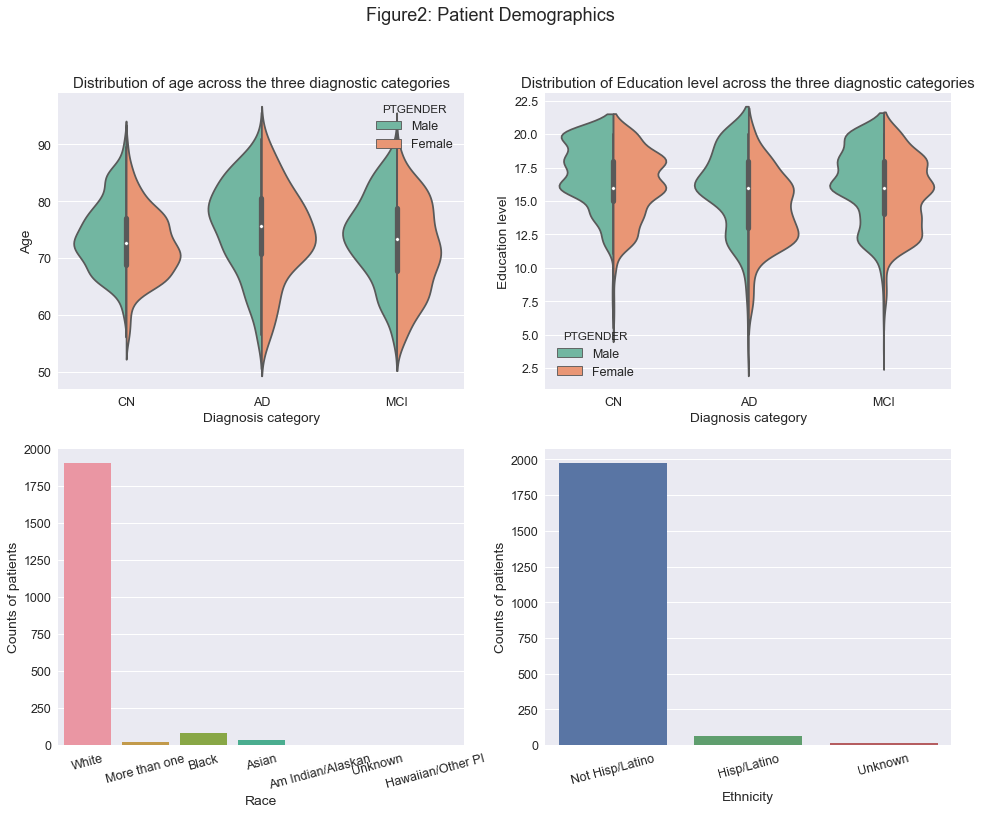

In [115]:
sns.set(font_scale = 1.25)
f, axes = plt.subplots(2, 2, figsize = (16, 12))

sns.violinplot(x = 'DX', y = 'AGE', hue = 'PTGENDER', data = demographics[['DX', 'AGE', 'PTGENDER']], split=True, palette="Set2", ax = axes[0, 0])
axes[0,0].set_xlabel('Diagnosis category')
axes[0,0].set_ylabel('Age')
axes[0,0].set_title('Distribution of age across the three diagnostic categories')

sns.violinplot(x = 'DX', y = 'PTEDUCAT', hue = 'PTGENDER', data = demographics[['DX', 'PTEDUCAT', 'PTGENDER']], split=True, palette="Set2", ax = axes[0, 1])
axes[0,1].set_xlabel('Diagnosis category')
axes[0,1].set_ylabel('Education level')
axes[0,1].set_title('Distribution of Education level across the three diagnostic categories')


sns.countplot(x = 'PTRACCAT', data = demographics[['PTRACCAT']], ax = axes[1,0])
axes[1,0].set_xlabel('Race')
axes[1,0].set_ylabel('Counts of patients')
plt.setp(axes[1,0].get_xticklabels(), rotation=15)

sns.countplot(x = 'PTETHCAT', data = demographics[['PTETHCAT']], ax = axes[1, 1])
axes[1,1].set_xlabel('Ethnicity')
axes[1,1].set_ylabel('Counts of patients')
plt.setp(axes[1,1].get_xticklabels(), rotation=15)
f.suptitle('Figure2: Patient Demographics')

PTMARRY
Divorced         AxesSubplot(0.125,0.125;0.775x0.755)
Married          AxesSubplot(0.125,0.125;0.775x0.755)
Never married    AxesSubplot(0.125,0.125;0.775x0.755)
Unknown          AxesSubplot(0.125,0.125;0.775x0.755)
Widowed          AxesSubplot(0.125,0.125;0.775x0.755)
Name: DX, dtype: object

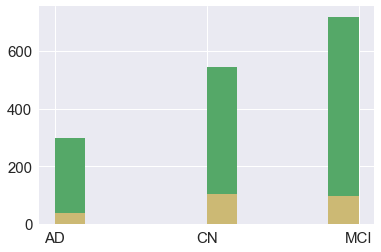

In [94]:
demographics.groupby(['PTMARRY'])['DX'].hist()

In [139]:
psychological_exams = ['PTEDUCAT', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FSVERSION']
psych = baseline_only_2[psychological_exams]

In [136]:
demographics.drop_duplicates('PTRACCAT')

,DX,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY
0,CN,74.3,Male,16,Not Hisp/Latino,White,Married
20,AD,75.4,Male,10,Hisp/Latino,More than one,Married
34,CN,65.4,Male,9,Not Hisp/Latino,Black,Married
179,MCI,79.7,Male,18,Not Hisp/Latino,Asian,Married
2278,MCI,64.5,Female,12,Not Hisp/Latino,Am Indian/Alaskan,Married
3063,MCI,56.3,Female,13,Hisp/Latino,Unknown,Divorced
6207,MCI,74.3,Female,14,Not Hisp/Latino,Hawaiian/Other PI,Married


In [118]:
def is_unique_tuple(list_of_tuples, curr_tuple):
    reverse_tuple = (curr_tuple[1], curr_tuple[0])
    if (curr_tuple in list_of_tuples or reverse_tuple in list_of_tuples): 
        return False 
    else: 
        return True
    
def find_highly_correlated_columns(df): 
    corr_df = df.corr()
    cols = corr_df.columns
    correlations = []
    correlated_cols = []
    keep_track = []
    for row in cols: 
        for col in cols:  
            if row!=col and is_unique_tuple(correlated_cols, (row, col)):
                correlations.append(corr_df.loc[row][col])
            if corr_df.loc[row][col] == 1.0 and row != col and is_unique_tuple(correlated_cols , (row, col)): 
                correlated_cols.append((row, col))
    
    correlations = np.array(correlations)
    correlations = correlations[~np.isnan(correlations)]
    return correlated_cols, np.array(correlations)


In [119]:
correlated_columns, correlations = find_highly_correlated_columns(baseline_only_2)
print(correlated_columns)
to_remove = [idx for idx, val in correlated_columns]
print(to_remove)

[('FDG', 'FDG_bl'), ('AV45', 'AV45_bl'), ('CDRSB', 'CDRSB_bl'), ('ADAS11', 'ADAS11_bl'), ('ADAS13', 'ADAS13_bl'), ('ADASQ4', 'ADASQ4_bl'), ('MMSE', 'MMSE_bl'), ('RAVLT_immediate', 'RAVLT_immediate_bl'), ('RAVLT_learning', 'RAVLT_learning_bl'), ('RAVLT_forgetting', 'RAVLT_forgetting_bl'), ('RAVLT_perc_forgetting', 'RAVLT_perc_forgetting_bl'), ('LDELTOTAL', 'LDELTOTAL_BL'), ('DIGITSCOR', 'DIGITSCOR_bl'), ('TRABSCOR', 'TRABSCOR_bl'), ('FAQ', 'FAQ_bl'), ('MOCA', 'MOCA_bl'), ('EcogPtMem', 'EcogPtMem_bl'), ('EcogPtLang', 'EcogPtLang_bl'), ('EcogPtVisspat', 'EcogPtVisspat_bl'), ('EcogPtPlan', 'EcogPtPlan_bl'), ('EcogPtOrgan', 'EcogPtOrgan_bl'), ('EcogPtDivatt', 'EcogPtDivatt_bl'), ('EcogPtTotal', 'EcogPtTotal_bl'), ('EcogSPMem', 'EcogSPMem_bl'), ('EcogSPLang', 'EcogSPLang_bl'), ('EcogSPVisspat', 'EcogSPVisspat_bl'), ('EcogSPPlan', 'EcogSPPlan_bl'), ('EcogSPOrgan', 'EcogSPOrgan_bl'), ('EcogSPDivatt', 'EcogSPDivatt_bl'), ('EcogSPTotal', 'EcogSPTotal_bl'), ('Ventricles', 'Ventricles_bl'), ('Hipp

Text(0.5,1,'Figure 4: Distribution of Correlations between pairs of features in the merged data')

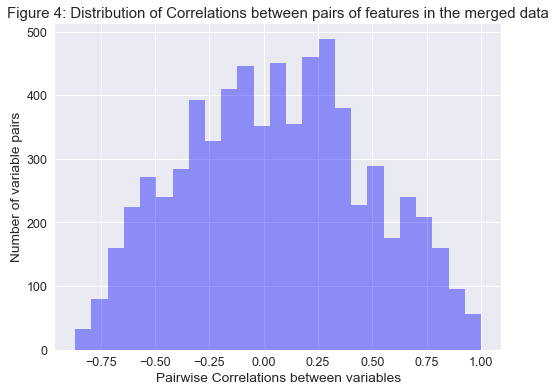

In [132]:
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize= (8, 6))
sns.distplot(correlations, bins = 25, kde= False, color = 'b', ax= ax)
ax.set(xlabel='Pairwise Correlations between variables', ylabel='Number of variable pairs')
ax.set_title('Figure 4: Distribution of Correlations between pairs of features in the merged data')
#fig.